# TERA - Aula 27
## Clustering

Objetivos gerais de algoritmos de clustering:
- Análise exploratória dos dados
- Encontrar padrões e estruturas
- Agrupar dados de forma a criar representações sumarizadas (sumarização de dados)

# Índice

- [Exemplo inicial](#Exemplo-Inicial)
- [K-Means](#K-Means)
 - [Case K-Means Elo7](#Case-Cluster-Usuários-Elo7)
- [DBSCAN](#DBSCAN)
- [Case Elo7 - Cluster Frete](#Case-Elo7---Clustering-de-Frete)
- [Hierarchical Clustering](#Hierarchical-Clustering)
 - [Exercício Prático](#Exercício-prático-Hierarchical-Clustering)
- [Comparação Métodos Clustering](#Comparação-métodos-clustering:)
- [Case Elo7 - Motivos de Compra](#Case-Elo7---Motivos-de-Compra)

### Exemplo Inicial
Análise exploratória do comportamento dos usuários do Elo7.

Dataset:
- `tempo` (float): Tempo em segundos que um usuário permanece no site.
- `ticket` (float): Valor gasto em reais no site.

In [1]:
# Imports usados no curso
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-colorblind')

In [2]:
# Pasta contendo os dados:
ROOT_FOLDER = os.path.realpath('..')
DATASET_FOLDER = os.path.join(ROOT_FOLDER,'datasets')

In [3]:
# Leitura dos dados
df_user_elo7 = pd.read_csv(os.path.join(DATASET_FOLDER, 'user_patterns_elo7_dataset.csv'), sep=';')

df_user_elo7.head(5)

,tempo,ticket
0,138.492732,63.029202
1,306.160891,75.160275
2,264.210040,74.064756
3,326.972183,95.059350
4,268.796360,47.015198


#### Análise Exploratória
- Média
- Covariância
- Tendência (Regressão Linear)

In [4]:
# Valor médio
user_elo7_mean = df_user_elo7.mean().values

# Covariância
user_elo7_cov = np.cov(df_user_elo7.values[:,0], df_user_elo7.values[:,1])

# Tendência - regressão
a, b, r, p, std_err = ss.linregress(df_user_elo7.values[:,0],df_user_elo7.values[:,1])
f = lambda x: a*x + b

In [5]:
print('- Média: {}'.format(user_elo7_mean))
print('- Covariância: \n{}'.format(user_elo7_cov))
print('- Coeficiente de correlação da regressão: {:.2f}'.format(r))

- Média: [ 718.41305716   95.82494287]
- Covariância: 
[[ 123372.18378516    6828.07629486]
 [   6828.07629486    1709.87352627]]
- Coeficiente de correlação da regressão: 0.47


Esses dados parecem interessantes, mas não são suficientes. Precisamos sempre observar os dados para tirar insights!

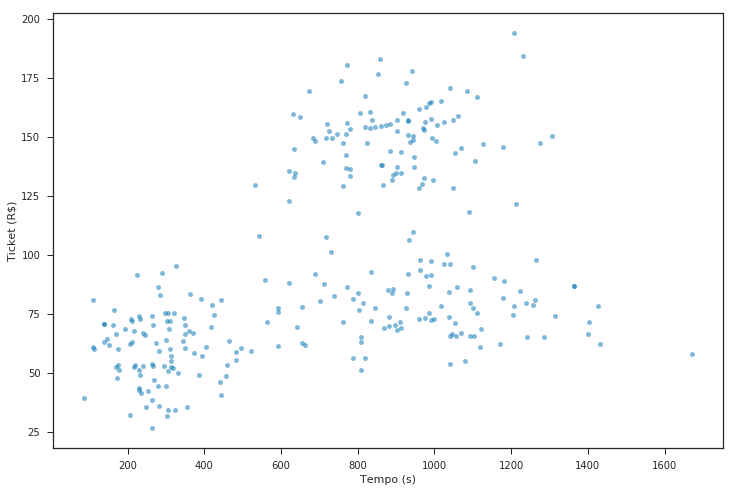

In [6]:
# Vamos plotar o gráfico
df_user_elo7.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')
plt.show()

In [7]:
### Função auxiliar para plotar a elipse de confiança ###
from matplotlib.patches import Ellipse

def get_confidence_ellipse(x, y, nstd=2):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='red', 
                  fill=False)
    return ell

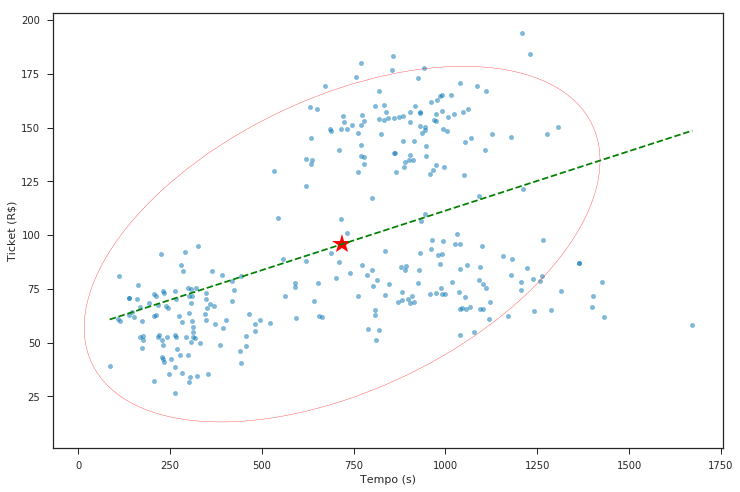

In [8]:
# Vamos plotar os dados no gráfico
df_user_elo7.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')

# Média
plt.plot(user_elo7_mean[0], user_elo7_mean[1], '*r', markersize=20)

# 2 desvios padrão
ell = get_confidence_ellipse(x=df_user_elo7.values[:,0],
                             y=df_user_elo7.values[:,1])
ax = plt.gca()
ax.add_patch(ell)

# Tendência
x = np.array([min(df_user_elo7.values[:,0]),max(df_user_elo7.values[:,0])])
plt.plot(x, f(x), '--g')

plt.show()

Há algo estranho nessa análise?
- A análise está matematicamente correta, mas talvez não seja completa;
- Precisamos levar em consideração possíveis grupos diferentes de usuários dentro dos dados. Quantos grupos você vê? Talvez entre 2 e 4 clusters?

Vamos utilizar o famoso algoritmo [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) para encontrar esses clusters. Podemos utilizar a implementação do [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para isso.

In [9]:
# TODO
# Importe o módulo do KMeans
from sklearn.cluster import KMeans

# Crie uma instância do K-Means pelo sklearn
# Teste diferentes números de clusters
n = 3
kmeans = KMeans(n_clusters=n)

Agora podemos encontrar os clusters.

In [10]:
kmeans.fit(df_user_elo7.values)
labels = kmeans.labels_

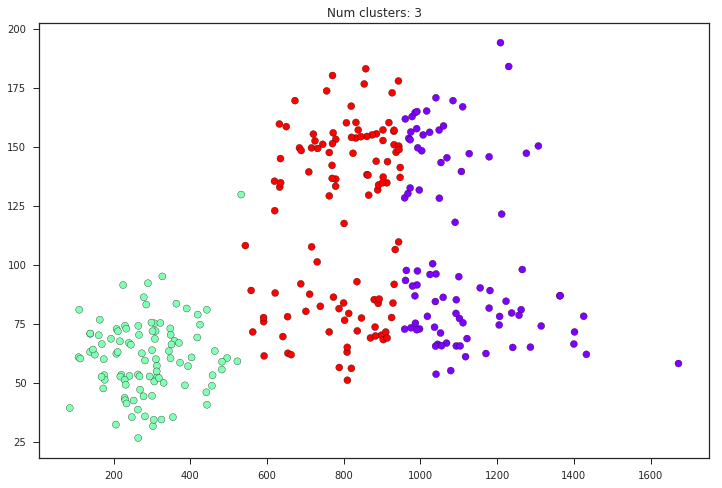

In [11]:
plt.scatter(x=df_user_elo7.values[:,0],
            y=df_user_elo7.values[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(n))
plt.show()

Os clusters estão como esperado?

In [12]:
# Vamos normalizar os dados!
from sklearn.preprocessing import StandardScaler

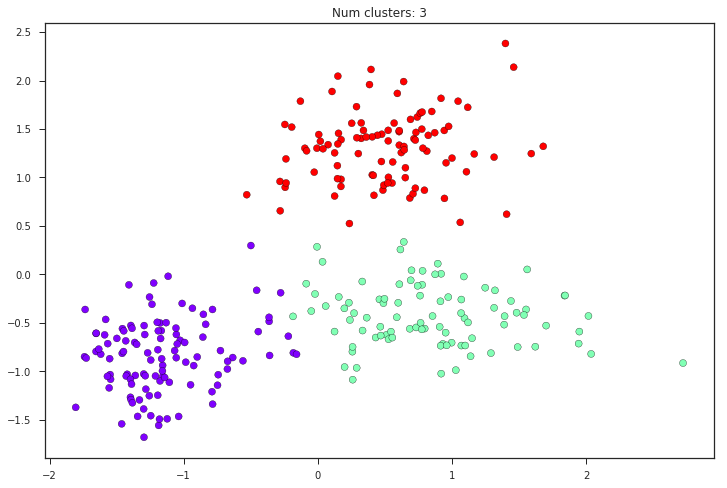

In [13]:
X = df_user_elo7.values

# Dados normalizados
X_scaled = StandardScaler().fit_transform(X)

kmeans.fit(X_scaled)
labels = kmeans.labels_
plt.scatter(x=X_scaled[:,0],
            y=X_scaled[:,1],
            c=labels.astype(np.float),
            cmap='rainbow',
            edgecolor='k')
plt.title('Num clusters: {}'.format(n))
plt.show()

---
## K-Means

#### Exemplo Clustering (opcional)

[Pular](#Case-Cluster-Usuários-Elo7)

Vamos para um problema clássico.
Utilizaremos o dataset Iris. O dataset contém os seguintes atributos:

- `sepal_length`: Comprimento da sépala da flor
- `sepal_width`: Largura da sépala
- `petal_length`: Comprimento da pétala
- `petal_width`: Largura da pétala
- `species`: Espécie da flor

![iris](https://cdn-images-1.medium.com/max/1600/1*1q79O5DCx_XNrAARXSFzpg.png)

In [14]:
# Importe o dataset
df_iris = pd.read_csv(os.path.join(DATASET_FOLDER,'iris_dataset.csv'))

df_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Como temos um vetor de features de 4 dimensões, não faz sentido tentarmos visualizar todas as dimensões em uma só figura. Entretanto, podemos visualizar a relação entre cada uma de suas features através de um mapa de dispersão pareado.

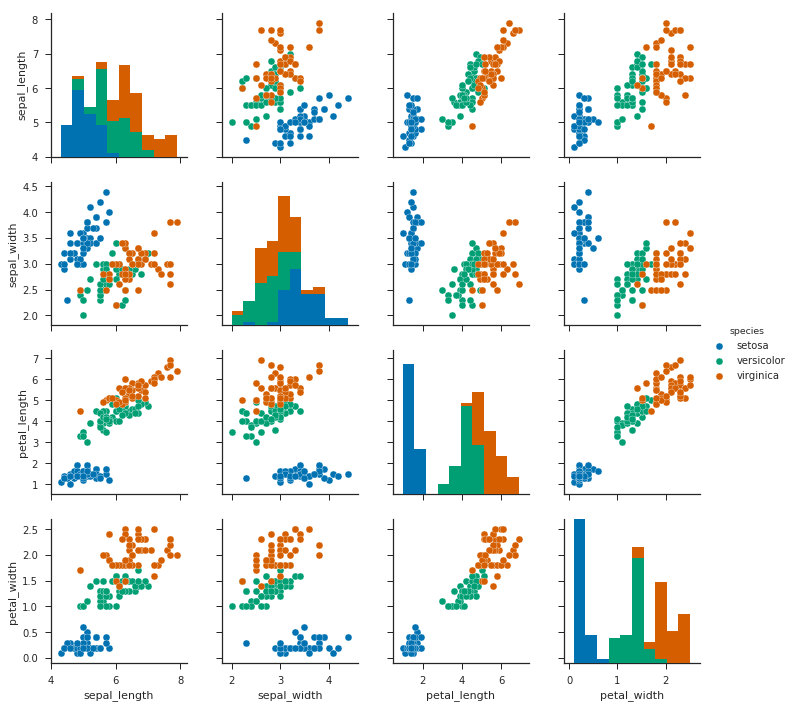

In [15]:
# Scatter plot pareado utilizando o Seaborn
sns.pairplot(df_iris, hue="species")
plt.show()

Podemos perceber que há uma boa separação de clusters utilizando as features `petal_length` e `petal_width`. Podemos utilizar apenas essas dimensões para a nossa análise.

In [16]:
# Separe o dataset utilizando apenas as features `petal_length` e `petal_width` do dataframe
# Coloque essas colunas em um numpy array (dica: utilize o atributo df[...].values)
X = df_iris[['petal_length','petal_width']].values

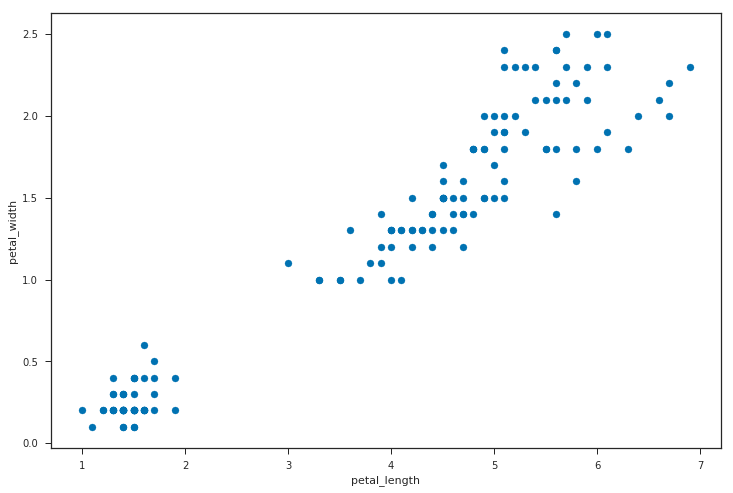

In [17]:
# Plot dos dados
plt.scatter(x=X[:,0],y=X[:,1])
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.show()

Nós já sabemos que existem três espécies no dataset, mas podemos tentar analisar se conseguiríamos encontrar esses clusters de maneira automática. Vamos utilizar o famoso algoritmo [**K-Means**](https://en.wikipedia.org/wiki/K-means_clustering) para achar esses clusters. Verifique no site do [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) mais detalhes de implementação do algoritmo.

In [18]:
# Importe o módulo do KMeans 
from sklearn.cluster import KMeans

# Crie uma instância do K-Means pelo sklearn
kmeans = KMeans(n_clusters=3)

In [19]:
# TODO
# Treine e aplique o modelo KMeans para o dataset X
results = kmeans.fit_predict(X)

In [20]:
# Crie uma coluna no dataframe df para incluir os resultados
df_iris['cluster'] = results

df_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species,cluster
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


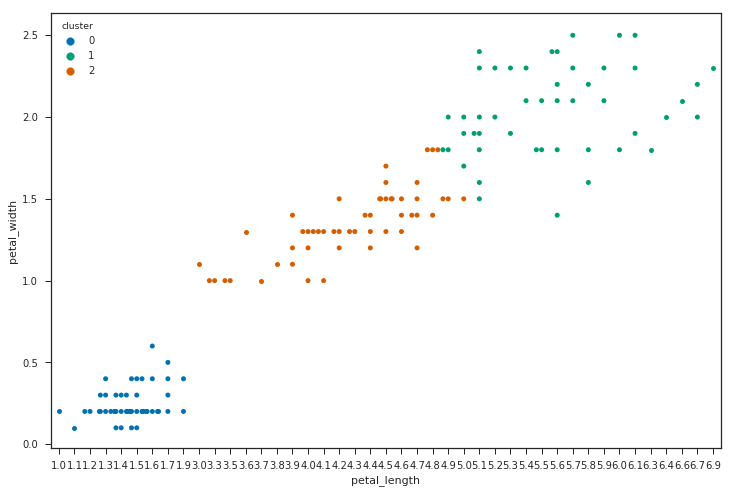

In [21]:
# Plote o mapa de dispersão (scatter plot) dos clusters gerados
# Veja o exemplo das moedas para se inspirar
sns.swarmplot(data=df_iris, x='petal_length', y='petal_width', hue='cluster')
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.show()

Os clusters formados fazem sentido? Veja novamente o gráfico da separação das espécies para ver se os clusters têm relação com elas.

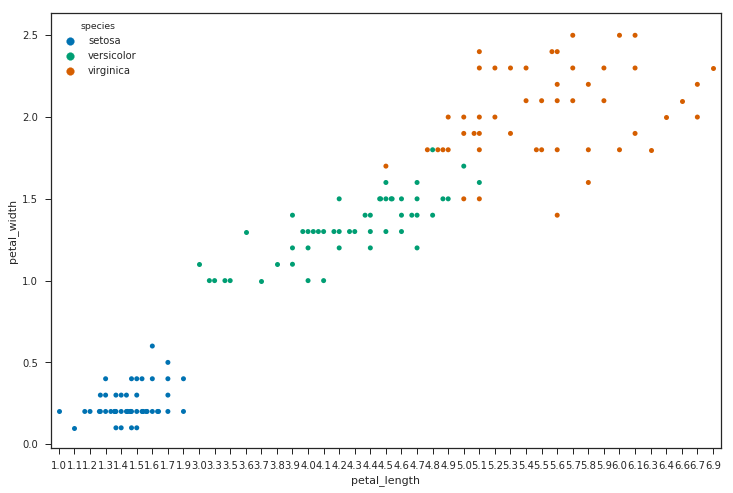

In [22]:
sns.swarmplot(data=df_iris, x='petal_length', y='petal_width', hue="species")
plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.show()

Podemos também utilizar a matriz de tabulação cruzada para verificar a relação dos clusters com as espécies.

In [23]:
# Apresente a matriz de cross-tabulation (Veja o exemplo das moedas)
ct = pd.crosstab(df_iris['cluster'], df_iris['species'])
print(ct)

species  setosa  versicolor  virginica
cluster                               
0            50           0          0
1             0           2         46
2             0          48          4


Quais são as conclusões? O K-Means funcionou do jeito que era esperado?

#### Escolha do número de clusters

Nós temos diversos métodos para escolher o número ideal de clusters. Alguns deles estão resumidos neste [artigo](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method). O método mais utilizado, entretanto, é o método do "cotovelo" (*elbow method*). 

Mas, antes de falarmos do método do cotovelo, nós precisamos definir o que é um bom cluster. É claro que isso depende de cada caso, mas as seguintes características são desejadas para a maioria dos clusters:
- Dados não muito dispersos -> Inércia
- Dados dentro dos clusters possuem perfil semelhante
- Quantidade aproximadamente uniforme de dados em cada cluster (controverso)

#### Inércia

A inércia de um cluster é definida como a soma das distâncias quadráticas de cada ponto de um cluster ao seu respectivo centroide, somada através de todos os clusters. Quanto maior é a inércia, maior será a dispersão dos clusters. Portanto, desejamos escolher um número de clusters que nos possibilite ter uma inércia baixa. Simples, mas temos um problema... O mínimo valor de inércia que podemos obter é quando cada ponto do nosso dataset pertence ao seu próprio cluster. Portanto, precisamos escolher um balanço entre baixa inércia e baixo número de clusters. 

Para isso, utilizamos o gráfico de cotovelo. O eixo horizontal do gráfico representa o número de clusters utilizados e o eixo vertical representa a inércia total dos clusters. O número de clusters ideal é definido como o ponto onde o gráfico se aproxima a uma horizontal (como o ponto de encontro do braço e antebraço).

Vamos apresentar o gráfico de inércia do problema anterior e verificar se escolhemos corretamente o número de clusters.

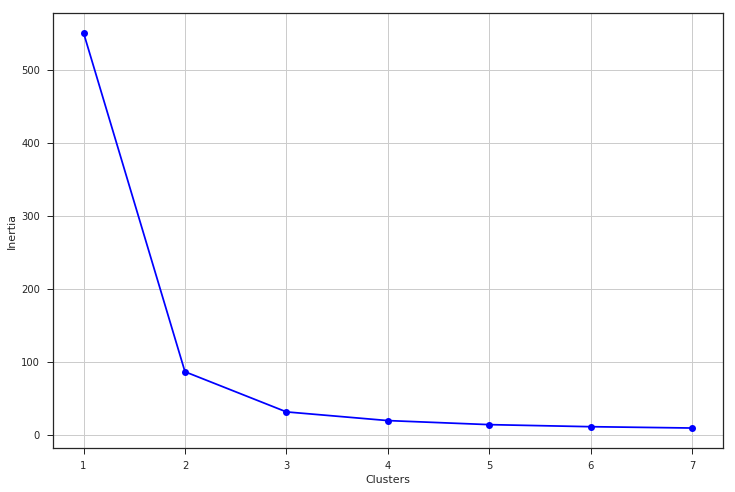

In [24]:
# Range de valores de clusters que vamos testar
k = range(1,8,1)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Podemos verificar que o número de clusters ideal é 3. Essa análise nos mostra que escolhemos corretamente o número de clusters.

---
## Case Cluster Usuários Elo7

Vamos encontrar o número ideal de clusters da distribuição de usuários do Elo7.

In [25]:
# Veja novamente os dados
df_user_elo7.head()

,tempo,ticket
0,138.492732,63.029202
1,306.160891,75.160275
2,264.210040,74.064756
3,326.972183,95.059350
4,268.796360,47.015198


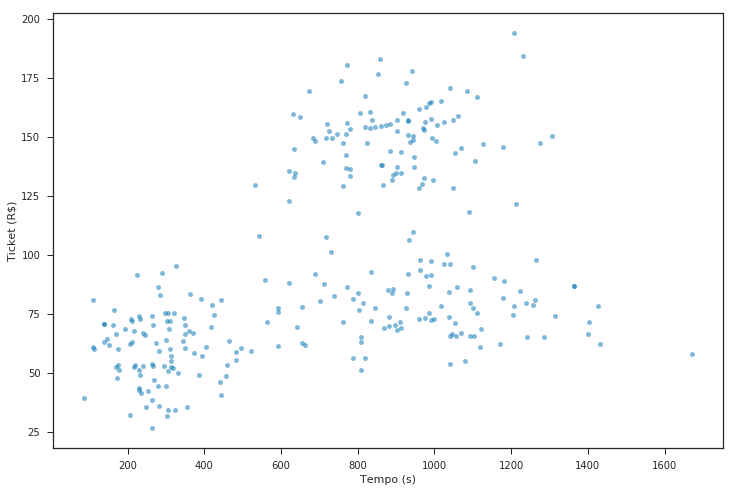

In [26]:
# Vamos plotar o gráfico
df_user_elo7.plot.scatter(x='tempo',y='ticket', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Ticket (R$)')
plt.show()

Explore o método K-Means para encontrar os clusters. Quantos clusters devemos escolher?

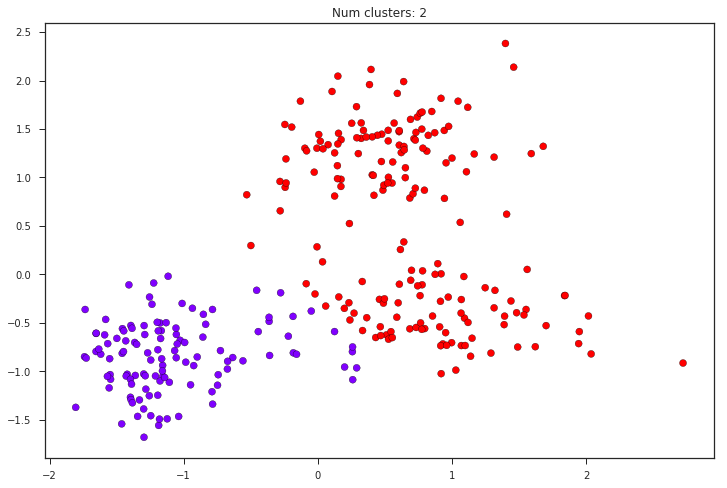

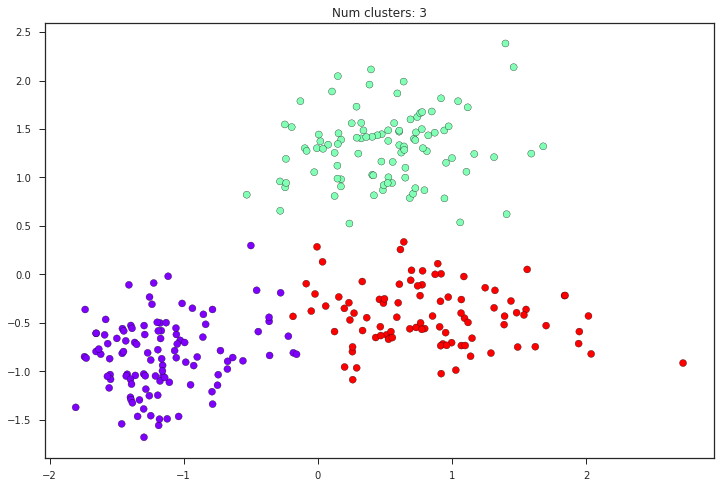

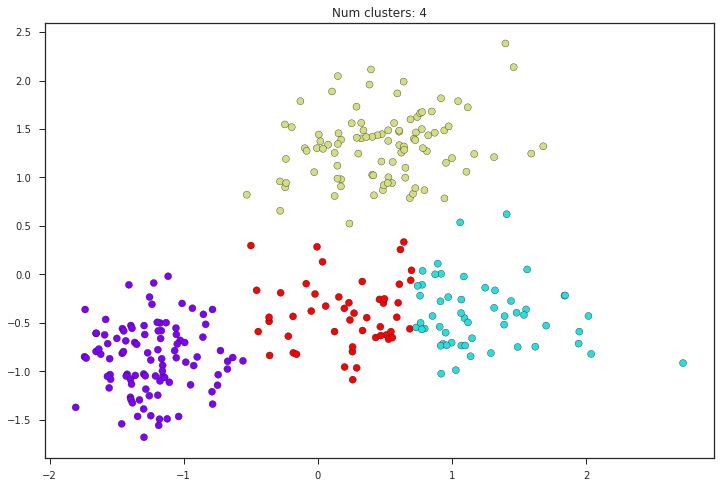

In [27]:
# E agora plotamos o resultado
n_clusters = range(2,5)

X = df_user_elo7.values

# Dados normalizados
X_scaled = StandardScaler().fit_transform(X)

for n in n_clusters:
    estimator = KMeans(n_clusters=n, random_state=170)
    estimator.fit(X_scaled)
    labels = estimator.labels_
    plt.scatter(x=X_scaled[:,0],
                y=X_scaled[:,1],
                c=labels.astype(np.float),
                cmap='rainbow',
                edgecolor='k')
    plt.title('Num clusters: {}'.format(n))
    plt.show()

Vamos encontrar o número ideal de clusters!

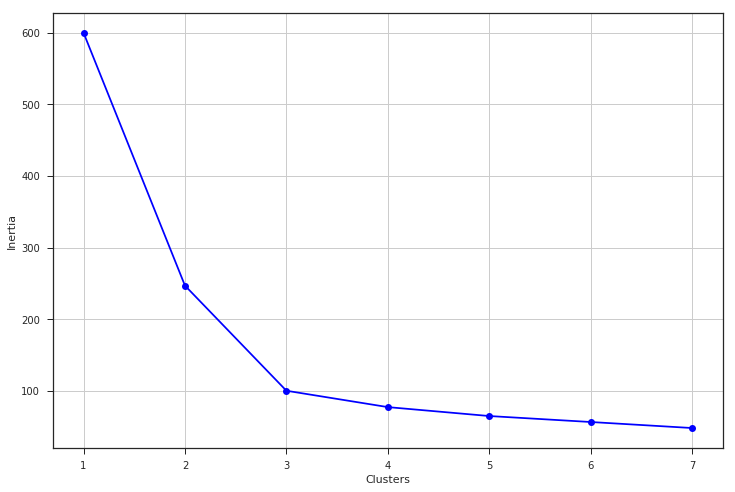

In [28]:
# Range de valores de clusters que vamos testar
k = range(1,8,1)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X_scaled)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Qual a sua opinião? Quantos clusters devemos utilizar?

---
## Case Elo7 - Clustering de Frete

Um dos problemas mais complicados do Elo7 é sua dependência dos correios. Nós sofremos muito com a falta de alternativas para dar aos nossos clientes (compradores e vendedores), já que o serviço dos correios além de caro, é também instável. 

Para tentar resolver esse problema, o time de Data Science do Elo7 foi chamado para tentar encontrar alguma alternativa. Após algumas conversas, nós levantamos a possibilidade de utilizarmos serviços de entrega independentes dos correios. Mas, o problema é que esses serviços necessitam de um volume grande de encomendas por ponto de coleta, o que não é o caso para a maioria dos vendedores cadastrados no Elo7. 

Uma possível solução seria encontrar pontos de coleta que pudessem agregar pedidos de vários vendedores e enviar de uma vez só com um desses serviços alternativos. Mas, como obtemos a localização desses pontos de coleta? Podemos aplicar um algoritmo de clustering nas rotas de frete mais frequentes!

Vamos tentar analisar os dados e verificar o que conseguimos obter. O dataset a seguir contém pares de endereços de origem e destino de entregas realizadas apenas na cidade de São Paulo em um curto intervalo de tempo.

In [29]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


Para facilitar os cálculos de distância, as latitudes e longitudes dos locais já foram realizados.

Vamos agora formar nosso vetor de features contendo as posições geográficas das nossas rotas.

*Dica: Será que é necessário normalizar as features?

In [30]:
# TODO
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

Quantos clusters vamos utilizar? (Obs: Podemos aplicar o método do cotovelo para descobrir.)

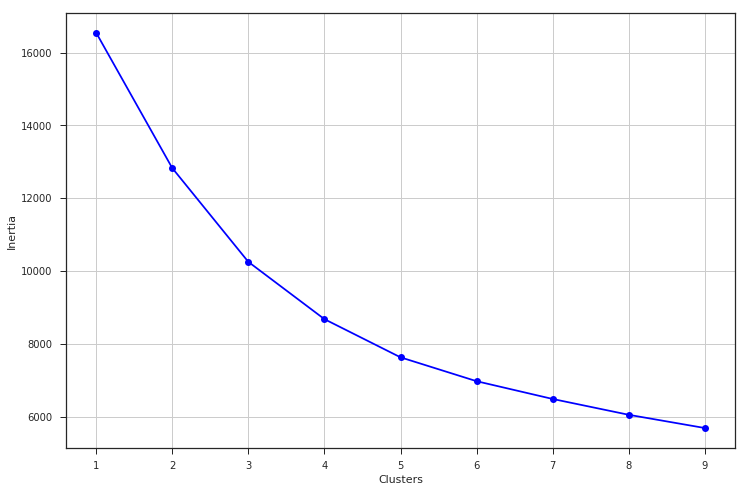

In [31]:
# TODO
# Range de valores de clusters que vamos testar
k = range(1,10,1)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X_scaled)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Agora podemos iniciar o algoritmo de clustering.

In [32]:
# TODO
kmeans = KMeans(n_clusters=5)

In [33]:
# TODO
labels = kmeans.fit_predict(X_scaled)

A análise da quantidade de ítens em cada cluster é sempre uma boa prática. Clusters desbalanceados são um sinal de que os dados não foram bem separados.

In [34]:
label, count = np.unique(labels, return_counts=True)
for l, c in zip(label,count):
    print('Cluster {}: {}'.format(l,c))

Cluster 0: 843
Cluster 1: 894
Cluster 2: 716
Cluster 3: 818
Cluster 4: 865


Vamos ver os gráficos para analisar qualitativamente os resultados.

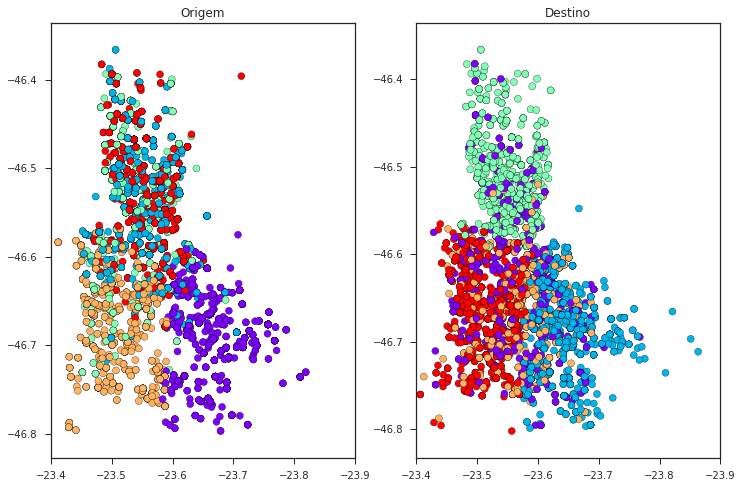

In [35]:
labels = kmeans.labels_

ax1 = plt.subplot(1,2,1)
ax1.set_title('Origem')
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax1.set_xlim((-23.4,-23.9))

ax2 = plt.subplot(1,2,2)
ax2.set_title('Destino')
plt.scatter(x=X[:,2],
            y=X[:,3],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
ax2.set_xlim((-23.4,-23.9))

plt.show()

O que achou? É possível perceber clusters bem definidos? Será que podemos utilizar esses clusters para resolver nossos problemas de frete?

---
### Exemplo Prático - Kaggle NYC Taxi Trip Duration

Dados:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

![iris](https://cdn.civitatis.com/estados-unidos/nueva-york/galeria/thumbs/taxi-nueva-york.jpg)

*Solução retirada do github de [juifa-tsai](https://github.com/juifa-tsai/NYC_Taxi_Trip_Duration).

Vamos realizar uma análise dos dados.

In [36]:
df_taxi = pd.read_csv(os.path.join(DATASET_FOLDER,'nyc_trip_duration_dataset.csv'))

In [37]:
df_taxi.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3070488,1,2016-05-10 09:36:01,2016-05-10 09:51:36,1,-73.960396,40.773849,-73.982414,40.775364,N,935
1,id3797315,1,2016-05-30 00:29:32,2016-05-30 00:34:08,1,-73.999039,40.734386,-74.007629,40.741051,N,276
2,id2982351,1,2016-02-13 22:03:12,2016-02-13 22:13:08,2,-74.012695,40.701694,-74.011086,40.729237,N,596
3,id0576937,2,2016-05-15 00:19:30,2016-05-15 00:39:14,1,-73.950188,40.783958,-73.867882,40.845356,N,1184
4,id3672156,1,2016-01-20 08:59:47,2016-01-20 09:18:15,1,-74.001541,40.746754,-73.978409,40.750282,N,1108


Podemos utilizar diversas abordagens para analisar os dados. Vamos tentar verificar os dados de localização dos passageiros.

In [38]:
df_map = df_taxi[['pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']]
df_pick = df_map[['pickup_longitude','pickup_latitude']]
df_drop = df_map[['dropoff_longitude','dropoff_latitude']]

Vamos visualizar os dados.

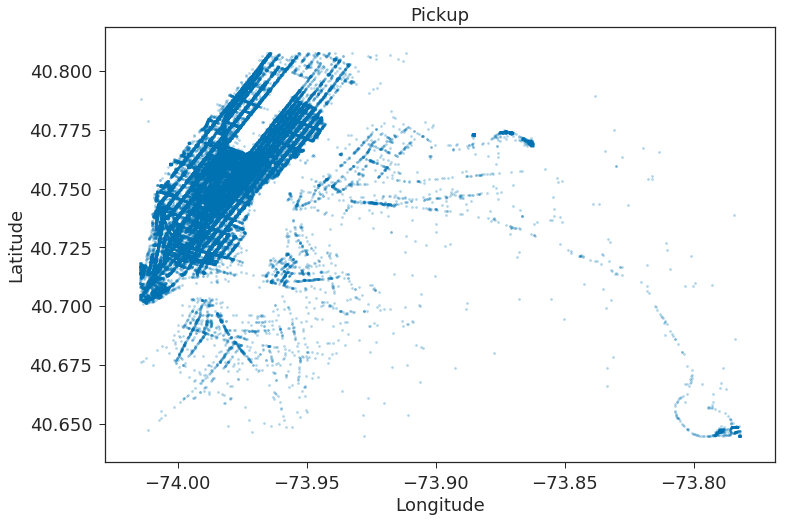

In [39]:

def plot_map(df, zoom=0.9):
    cutmap = zoom/100

    x = df['pickup_longitude']
    y = df['pickup_latitude']
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    x_plot = x[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    y_plot = y[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)]
    plt.scatter(x=x_plot, y=y_plot, s=5, alpha=0.3)
    plt.tick_params(labelsize=18)
    plt.title('Pickup', fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)
    plt.show()

plot_map(df_taxi)

A distribuição dos dados é bem interessante. Podemos verificar que existe uma concentração grande de pontos dentro da ilha de Manhattan, o que é esperado.

Como segundo passo da análise dos dados, nós podemos tentar enriquecê-los utilizando técnicas de feature engineering e clustering. Vamos explorar o segundo em seguida.

O racional de utilizar clustering para análise exploratória e feature engineering é o fato de encontrar estruturas implícitas nos dados. Por exemplo, se tentássemos observar cada passageiro individualmente, talvez teríamos dificuldade em encontrar um padrão nos dados. Mas, é intuitivo pensar que passageiros semelhantes (mesma localização, horário etc) possam ser agrupados e tratados como um só. Assim, podemos tratar os dados por grupos controlados de passageiros, ao invés de cada indivíduo.

Vamos tentar encontrar clusters nos dados de início da corrida de taxi.

In [40]:
kmeans = KMeans(n_clusters=20)

In [41]:
X_kmeans = kmeans.fit_predict(df_pick)
df_pick['zone']  = X_kmeans

/home/rballet/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


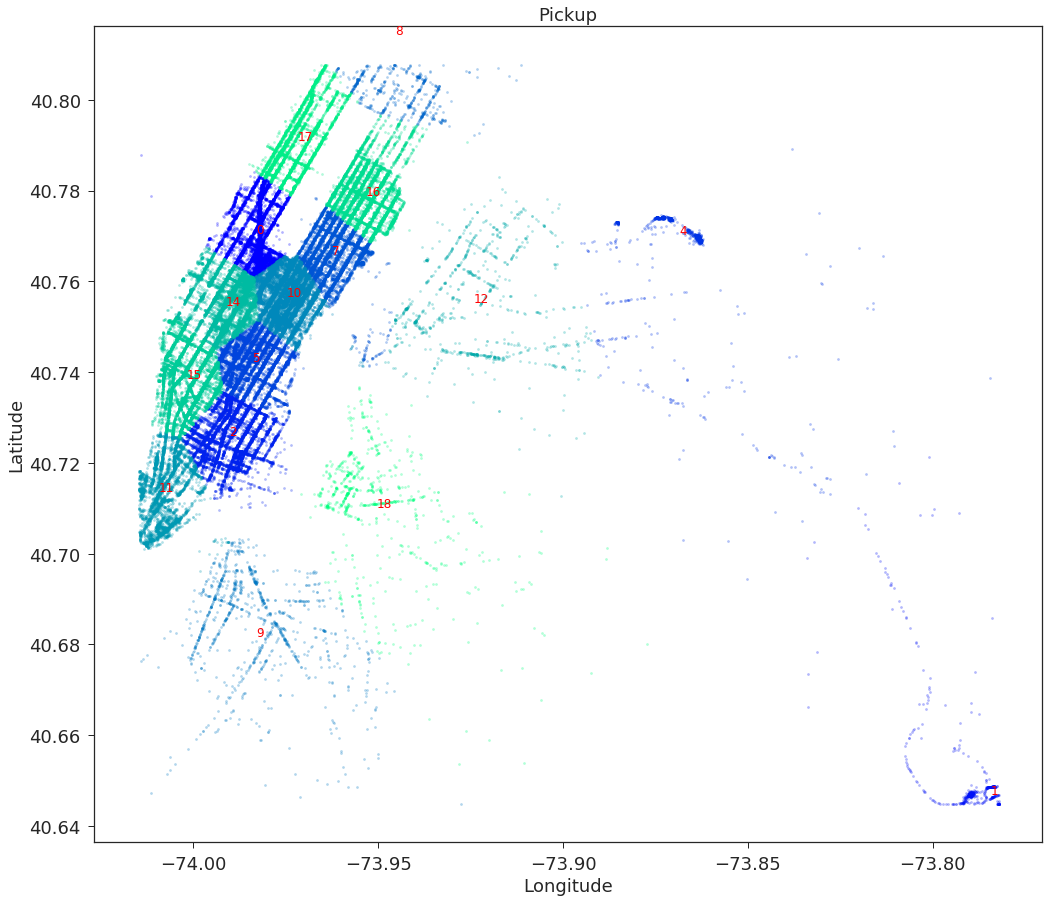

In [42]:
def draw_map_zone( df, x_name, y_name, z_name, name, zoom=0.9, cluster=None ):

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]

    cutmap = zoom/100
    x_max, x_min = x.quantile(1-cutmap), x.quantile(cutmap)
    y_max, y_min = y.quantile(1-cutmap), y.quantile(cutmap)
    
    zones = np.unique(z[(x>x_min) & (x<x_max) & (y<y_max) & (y>y_min)])

    #cmap = plt.get_cmap('spectral') 
    cmap = plt.get_cmap('winter') 
    colors = [cmap(i) for i in np.linspace(0, 1, len(zones))]

    for i, zone in enumerate(zones):       
        plt.scatter( x=x[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     y=y[ (z==zone) & (x>x_min) & (x<x_max) & (y<y_max) & (y>y_min) ], 
                     s=5, alpha=0.3, c=colors[i])
        if cluster:
            plt.text( cluster.cluster_centers_[zone,0], cluster.cluster_centers_[zone,1], str(zone), fontsize = 12, color='r')

    plt.tick_params(labelsize=18)
    plt.title(name, fontsize=18 )
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude',  fontsize=18)


plt.figure(figsize=(17,15))
draw_map_zone(df_pick, 'pickup_longitude', 'pickup_latitude', 'zone', 'Pickup', cluster=kmeans)
plt.show()

Não por acaso, os clusters encontrados se assemelham aos bairros de Nova Iorque. Esses clusters agora podem ser utilizados de diversas formas:
- Podemos explorar a distribuição das outras features dentro de cada um dos clusters. Assim poderemos ver o quanto cada região se diferença das outras.
- Podemos também utilizar agora as labels obtidas pelo algoritmo de clustering como entrada de outros algoritmos de machine learning. Essa técnica é muito utilizada para melhorar a precisão dos algoritmos de regressão e classificação.

Vamos tentar utilizar clustering na solução encontrada na [aula 15](https://github.com/somostera/tera-dsc-abr2018/blob/master/15-ml-with-decision-trees/notebooks/Gabarito%20Aula%2015%20-%20AM%20com%20%C3%81rvores%20de%20Decis%C3%A3o.ipynb) para verificar se conseguimos aumentar a precisão do regressor.

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

In [44]:
kfold = KFold(n_splits=5,random_state=0)

df_taxi_cluster = df_taxi.copy()

kmeans = KMeans(n_clusters=100)
X_kmeans = kmeans.fit_predict(df_map)
df_taxi_cluster['zone'] = X_kmeans

x = df_taxi.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)
y = df_taxi['trip_duration']

x_cluster = df_taxi_cluster.drop(['trip_duration', 'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)

reg = DecisionTreeRegressor()

In [45]:
def make_cv_prediction(x,y,train_index,test_index,reg):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    return y_pred, y_test

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test,y_pred))

rmsle_cv_default = []
rmsle_cv_cluster = []
for train_index, test_index in kfold.split(x,y):
    y_pred, y_test = make_cv_prediction(x,y,train_index,test_index,reg)
    rmsle_cv_default.append(rmsle(y_test, y_pred))
    
    y_pred_cluster, y_test = make_cv_prediction(x_cluster,y,train_index,test_index,reg)
    rmsle_cv_cluster.append(rmsle(y_test, y_pred_cluster))

In [46]:
print('Default: {:.4f}'.format(np.mean(rmsle_cv_default)))
print('Cluster: {:.4f}'.format(np.mean(rmsle_cv_cluster)))

Default: 0.6834
Cluster: 0.6725


Pode-se notar um ligeiro aumento de precisão do estimador ao utilizar o cluster.

---
## Hierarchical Clustering

Vamos agora aprender sobre outro método de clustering: [**Hierarchical Clustering**](https://en.wikipedia.org/wiki/Hierarchical_clustering). Como o nome mesmo diz, ele utiliza o conceito de *hierarquia* para construir os clusters. Existem duas principais variações do algoritmo: aglomerativo e por divisão. O primeiro é mais usado na prática. O passo a passo do algoritmo é apresentado abaixo:

- Primeiro colocamos todos as observações em clusters próprios;
- Depois, iterativamente procuramos os clusters mais próximos\* e agrupamos eles em um novo cluster;
- Repetimos o passo anterior até formarmos um único cluster com todas as observações.

\*Obs: A definição de distância (ou similaridade) entre clusters depende do tipo de métrica de distância (Euclidiana, Manhattan, cosseno etc) e ligação (Ward, simples, completa etc).

Como podemos ver no algoritmo, o objetivo é a criação de um grande cluster que agrupe todos os dados. Nós podemos visualizar esse histórico de agrupamentos a partir de um [dendrograma](https://en.wikipedia.org/wiki/Dendrogram). A então criação de clusters mais granulares depende da região de similaridade que se deseja realizar o corte.

---
### Exercício Hierarchical Clustering

Vamos praticar agora!
Utilizaremos o dataset do [Eurovision de 2016](https://eurovision.tv/history/full-split-results) para essa tarefa. Esse evento é uma competição de músicas entre países. Cada país participante seleciona uma música para concorrer com as outras. Ao final, cada país deve votar nas músicas com pontuações entre [1,2,3,4,5,6,7,8,10,12]. Um país pode votar tanto através de um juri formado oficialmente pelo país ou via votos por telefone. Ao final, ganha o país que receber a maior quantidade de pontos.

Essa competição é famosa por apresentar um comportamento indesejado: os países próximos geografica e culturalmente tendem a se favorecer. Por essa razão há sempre mudanças nas regras para tentar evitar que isso aconteça. Será que conseguiremos perceber esse comportamento através de um algoritmo de clustering? Vamos tentar!

Um país não pode votar em si próprio, mas, para podermos fazer a nossa análise, considerei que um país daria a pontuação máxima (12) para ele próprio.

As colunas do dataset são descritas a seguir e consideramos apenas votos feitos por telefone:

- `From country`: País votante
- `Televote Points`: Pontuação dada por telefone pelo país votante
- `To country`: País que recebeu a pontuação do país votante

![Eurovision](https://www.eurovisionary.com/wp-content/uploads/2015/11/eurovision-2016.jpg)

In [47]:
# Vamos iniciar a leitura do dataset
df_euro = pd.read_csv(os.path.join(DATASET_FOLDER, 'eurovision_dataset.csv'), sep=';')

df_euro.head(5)

,From country,Televote Points,To country
0,Albania,2.0,Armenia
1,Albania,12.0,Australia
2,Albania,0.0,Austria
3,Albania,0.0,Azerbaijan
4,Albania,0.0,Belgium


In [48]:
# Podemos visualizar quem está ganhando nessa votação
df_euro_points = df_euro.groupby(['To country']).sum()
df_euro_points.sort_values(by='Televote Points', inplace=True, ascending=False)
df_euro_points.head(10)

,Televote Points
To country,
Russia,373.0
Ukraine,335.0
Poland,234.0
Australia,203.0
Bulgaria,192.0
Sweden,151.0
Armenia,146.0
Austria,132.0
France,121.0


Se formos considerar apenas os votos por telefone, a Russia está ganhando a competição!

Como fizemos para o exercício anterior, nós temos que tomar cuidado com a distribuição dos dados. como temos valores discretos e determinísticos de pontuação, não faz sentido analisarmos a variância dos dados. Entretanto, podemos normalizar os pontos em uma escala de 0-100%.

In [49]:
# Obtenha o vetor de pontos
X = np.array([i for i in df_euro.groupby('From country')['Televote Points'].apply(np.array)])

# TODO
# Realize a normalização dos dados
from sklearn.preprocessing import MaxAbsScaler
normalizer = MaxAbsScaler()

X_norm = normalizer.fit_transform(X)

Vamos realizar agora o algoritmo Hierarchical Clustering!

In [50]:
# Importe os métodos linkage (Hierarchical Clustering) e dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

In [51]:
# TODO
# Aplique o algoritmo Hierarchical Clustering utilizando o scipy
# Selecione uma métrica de distância e um método de ligação
# Teste vários para obter a intuição por trás de cada método
Y = linkage(X_norm, method='ward', metric='euclidean')

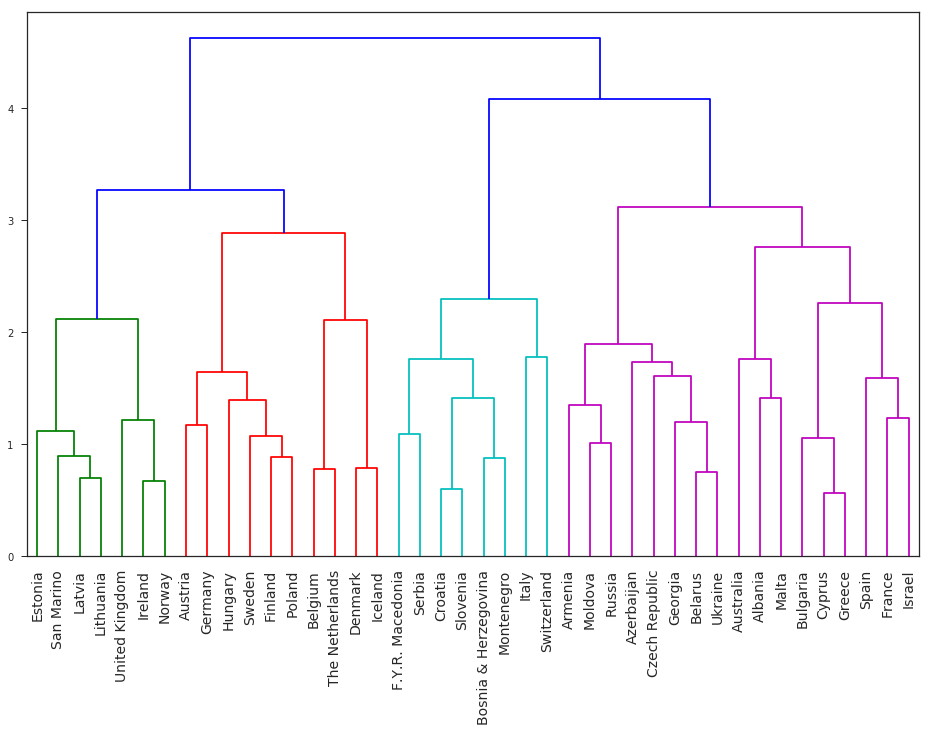

In [52]:
# TODO
# Crie o dendrograma para visualizar os resultados
# Será necessário obter os valores de labels que são os países
# *votantes* da competição (Dica: Procure pelo método unique do pandas)
plt.figure(figsize=(16,10))
labels = pd.unique(df_euro['From country'])
dendrogram(Y, 
           labels=labels, 
           leaf_rotation=90, 
           leaf_font_size=14) # Use o leaf_font_size = 14

plt.show()

O que podemos dizer sobre o dendrograma? Há alguma relação cultural, política ou geográfica entre os países? Se quiséssemos escolher uma região de corte para formar clusters intermediários, qual seria?

#### Exemplo Grãos (Opcional)

[Pular](#Comparação-métodos-clustering:)

Vamos utilizar o dataset de diferentes tipos de grãos de trigo obtidos pelo [UCI](https://archive.ics.uci.edu/ml/datasets/seeds#) para treinar esses conceitos.

O dataset contém os seguintes parâmetros:

- `area`: Área total do grão, A
- `perimeter`: Perímetro do grão, P
- `compactness`: Grão de compactação do grão - $C = \frac{4 \pi A}{P^2}$
- `length_kernel`: Comprimento do núcleo
- `width_kernel`: Largura do núcleo
- `asymmetry`: Coeficiente de assimetria
- `kernel_groove`: Comprimento do sulco do núcleo

Variedades de grãos: 'Kama' (1), 'Rosa' (2) e 'Canadian' (3)

In [53]:
# Importar os dados
df_grain = pd.read_csv(os.path.join(DATASET_FOLDER, 'seeds_dataset.csv'), sep=';')
df_grain.head(5)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry,kernel_groove,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama


Antes de iniciarmos o processo de clustering, vamos verificar se há muita discrepância entre as variâncias das features. Essa etapa é muito importante, porque features com variância elevada possuem maior influência na medida de distância do algoritmo do que features com menor variância, o que pode ser indesejado. Quando normalizamos as features, nós conseguimos dar influências iguais para todas elas.

In [54]:
df_grain.var()

area             8.466351
perimeter        1.705528
compactness      0.000558
length_kernel    0.196305
width_kernel     0.142668
asymmetry        2.260684
kernel_groove    0.241553
dtype: float64

Percebemos que o atributo `area` possui maior variância, enquanto o `compactness` possui baixa variância. Portanto, vamos primeiramente normalizar as features utilizando o [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) do scikit-learn. Ele normaliza as features individualmente deixando a variância delas igual a 1.

In [55]:
# Vamos importar o StandardScaler
from sklearn.preprocessing import StandardScaler

In [56]:
# Vamos criar agora o vetor de atributos
X = df_grain[['area','perimeter','compactness','length_kernel','width_kernel','asymmetry','kernel_groove']].values

In [57]:
# Agora precisamos normalizar o vetor de features

# Primeiro criamos uma instância do StandardScaler
normalizer = StandardScaler()

# Agora podemos normalizar através do método fit_transform
X_norm = normalizer.fit_transform(X)

# Podemos verificar que a variância de cada feature é 1
np.var(X_norm, axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.])

O scikit-learn possui um método próprio para o algoritmo de [Hierarchical Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering). Entretanto, ele não nos permite visualizar facilmente o dendrograma final. Por isso, vamos utilizar a versão do scipy.

In [58]:
# Importe os métodos linkage (Hierarchical Clustering) e dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

In [59]:
# Vamos escolher a métrica de distância:
distance = 'euclidean'
# Agora o tipo de ligação
linkage_type = 'complete'

# Vamos aplicar o método linkage
Y = linkage(X_norm, method=linkage_type, metric=distance)

In [60]:
Y.shape

(209, 4)

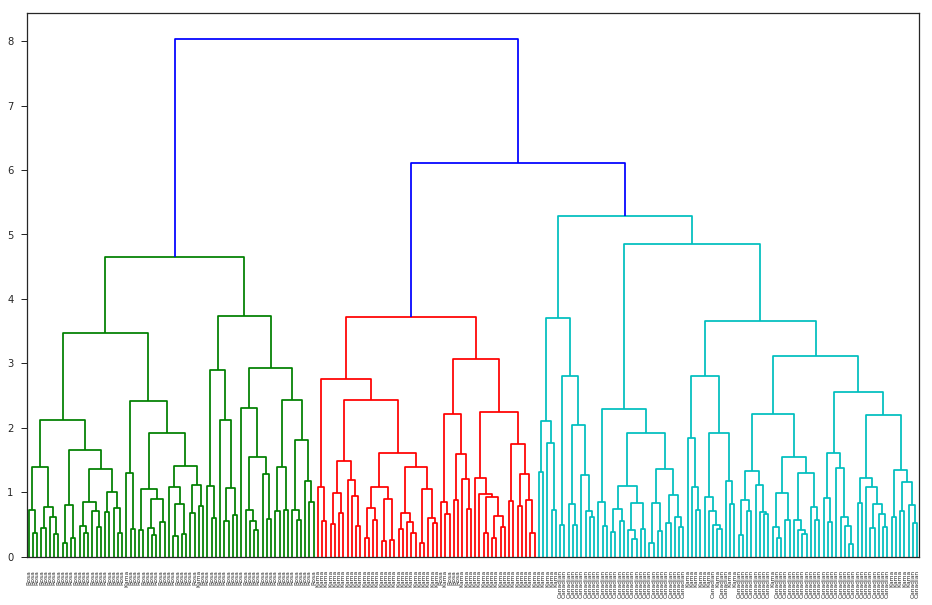

In [61]:
# Agora estamos prontos para plotar o dendrograma
# Vamos obter o nome das variedades dos grãos
varieties = df_grain['varieties'].values

# Construímos finalmente o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

Podemos notar que os clusters formados a partir do Hierarchical Clustering fazem bastante sentido com relação às variedades dos grãos de trigo. Vamos realizar agora um corte no dendrograma de forma a ficarmos com apenas 3 clusters, que representa uma distância de 6.

Para essa tarefa nós podemos usar o método [`fcluster`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.fcluster.html) do scipy. Ele nos permite realizar um corte na árvore de clustering gerada pelo Hierarchical Clustering.

In [62]:
from scipy.cluster.hierarchy import fcluster

In [63]:
# Vamos gerar os rótulos para os clustes
num_clusters = 3
labels = fcluster(Y, num_clusters ,criterion='maxclust')

In [64]:
labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2], dtype=int32)

In [65]:
# Vamos agora criar um dataframe para podermos utilizar o cross-tabulation do pandas
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Crie a matriz de tabulação cruzada
ct = pd.crosstab(df['labels'], df['varieties'])

print(ct)

varieties  Canadian  Kama  Rosa
labels                         
1                 0     2    66
2                 0    48     4
3                70    20     0


Podemos notar que o as variedades Canadian e Rosa foram muito bem agrupados nos clusters, mas a Kama não teve o mesmo sucesso. Vamos tentar utilizar o método "Ward" para a ligação e ver se há alguma variação.

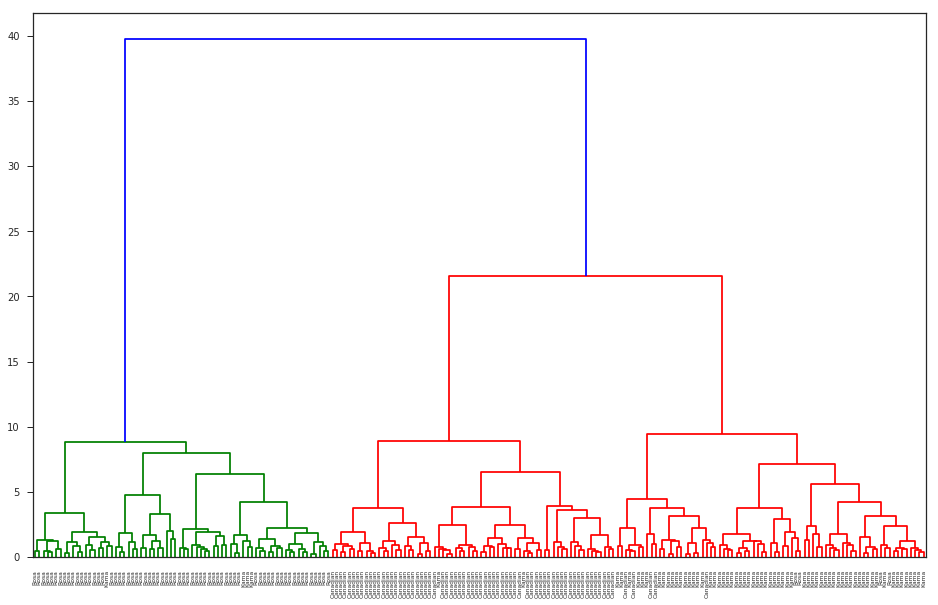

varieties  Canadian  Kama  Rosa
labels                         
1                 0     4    66
2                65     2     0
3                 5    64     4


In [66]:
# Distância
distance = 'euclidean'
# Ligação
linkage_type = 'ward'

# Treinar modelo Hierarchical Clustering
Y = linkage(X_norm, method=linkage_type, metric=distance)

# Plota dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

# Número de clusters
num_clusters = 3

# Obtem labels
labels = fcluster(Y, num_clusters ,criterion='maxclust')

# Vamos agora criar um dataframe para podermos utilizar o cross-tabulation do pandas
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Crie a matriz de tabulação cruzada
ct = pd.crosstab(df['labels'], df['varieties'])

print(ct)

Agora temos um resultado melhor para a variedade Kama, mas piorou um pouco o resultado para a Canadian. Dificilmente teremos um algoritmo que consegue ser perfeito em todos os casos. Mas, como podemos visualizar no dendrograma e na matriz de tabulação cruzada, nós conseguimos um bom resultado de clusterização.

---
## Comparação métodos clustering:

Vamos testar os 3 algoritmos utilizando alguns datasets padrão do scikit-learn.

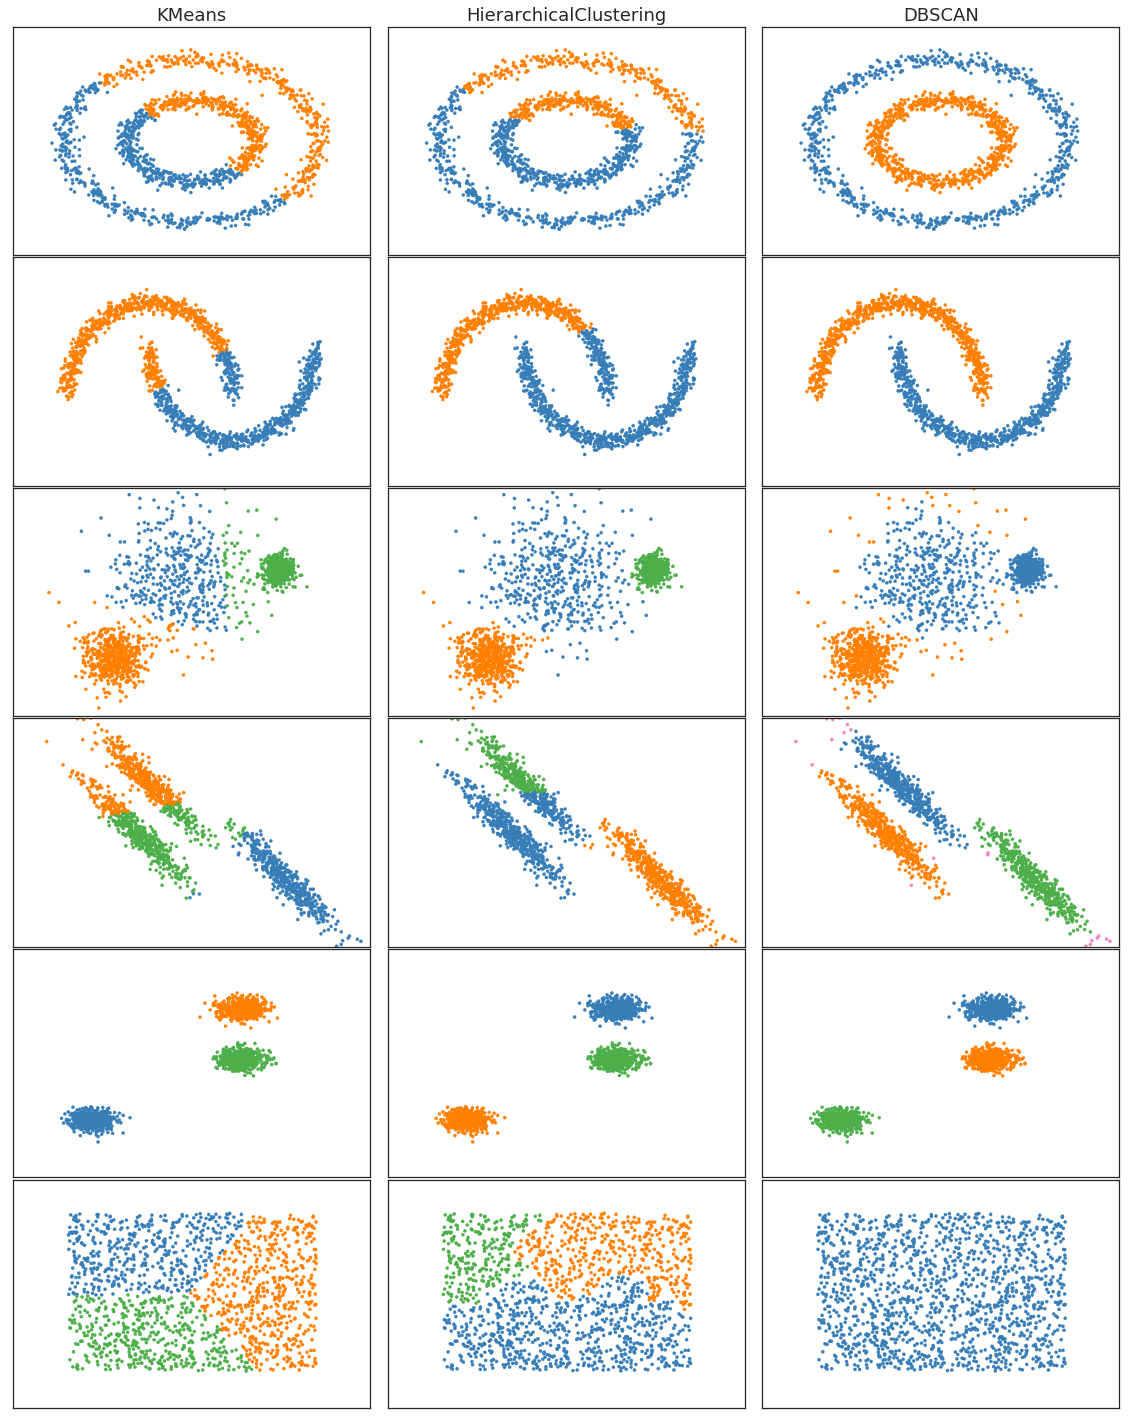

In [67]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Gera os dados
# ============
n_samples = 1500
# Circulos concentricos
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# Formato de lua
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# Bolas
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# Sem estrutura (uniforme)
no_structure = np.random.rand(n_samples, 2), None

# Dados distribuídos anisotropicamente
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Ajusta os parametros dos modelos e datasets
# ============
plt.figure(figsize=(16, 20))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

# Parametros dos modelos de clustering
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

# Parametros do dataset
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # Atualiza os parametros para o dataset especifico
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # Normaliza o dataset
    X = StandardScaler().fit_transform(X)

    # ============
    # Criação dos objetos de clustering
    # ============
    
    # K-Means
    two_means = cluster.KMeans(n_clusters=params['n_clusters'])
    
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    # Hierarchical Clustering - Aglomerativo
    ward = cluster.AgglomerativeClustering(
        linkage="ward",
        n_clusters=params['n_clusters'])

    clustering_algorithms = (
        ('KMeans', two_means),
        ('HierarchicalClustering', ward),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:
        algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.show()

---
# Case Elo7 - Motivos de Compra

Os compradores do Elo7 são incentivados a indicar o motivo da compra de determinado produto no seu marketplace. Esses motivos nos ajudam a entender melhor o **momento** de compra do usuário. O dataset apresentado a seguir contém um subset desses motivos de compra.

In [68]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


Existem muitos tipos possíveis de motivos de compra, mas será que nós podemos encontrar algum padrão neles? Me parece um problema clássico de **clustering**.

Vamos utilizar o Tf-Idf para criar o embedding dos motivos de compra e o K-Means para encontrar clusters.

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

Cria a matriz de embeddings.

In [103]:
# TODO
X = tfidf.fit_transform(df_reason['reason'].values)

Como escolher o número de clusters? Vamos utilizar o gráfico de inércias. (Obs: outra possibilidade é avaliar o ["silhouette score"](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)).

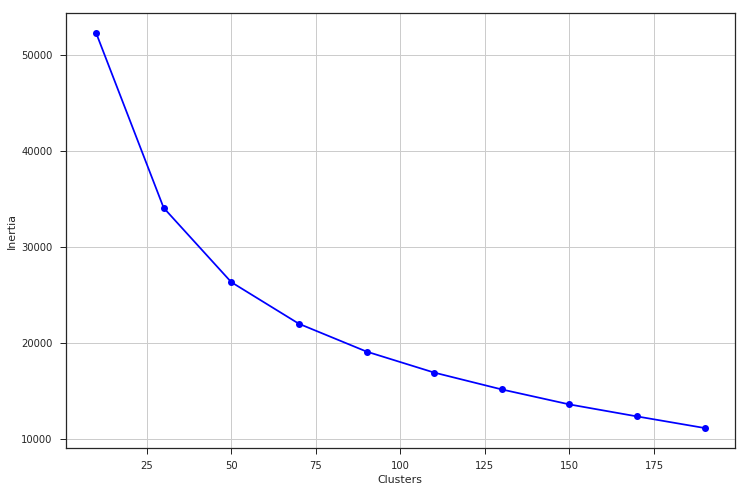

In [71]:
# TODO
# Range de valores de clusters que vamos testar
k = range(10,200,20)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

Inicializa o K-Means com a quantidade de clusters que escolhemos a partir do gráfico.

In [72]:
# TODO
kmeans = KMeans(n_clusters=50)

Treina o modelo K-Means.

In [73]:
# TODO
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Encontra os clusters para cada motivo de compra.

In [74]:
# TODO
labels = kmeans.predict(X)

Vamos agora visualizar os clusters criados.

In [75]:
# Crie um novo dataframe com os labels dos clusters
df = pd.DataFrame({'reason': df_reason['reason'], 'labels': labels})

df.head()

,labels,reason
0,44,festa de 2 anos do meu filho
1,39,presente para mim
2,1,aniversario
3,41,nascimento do meu bebe
4,15,casamento


Vamos verificar a distribuição de motivos em cada cluster. Quanto mais desbalanceado, pior.

In [76]:
df.groupby('labels').size()

labels
0       437
1      8874
2      6412
3      1950
4       433
5       740
6      1351
7      4795
8      6290
9      2041
10     2756
11     2087
12    12285
13     1151
14     1281
15     6260
16     1681
17     1455
18      936
19     1448
20     1372
21      379
22     1293
23      565
24     1299
25     1681
26     2073
27     1047
28      542
29     1025
30      213
31     1390
32     1775
33     1271
34     1738
35     1580
36      455
37      912
38      614
39     2349
40     1053
41      922
42     1324
43     1526
44     1081
45     1004
46     1272
47     1957
48     1320
49      305
dtype: int64

Podemos visualizar alguns exemplos de clusters gerados pelo K-Means.

In [77]:
for idx in range(50):
    idx_labels = df[df['labels']==idx]['reason'].unique()
    print('- Cluster {}:'.format(idx + 1))
    for i in np.random.choice(idx_labels, min(len(idx_labels), 10), replace=False):
        print(' '*5, i)
    print()

- Cluster 1:
      fazer artesanato
      faco artesanato
      artesanato
      material para artesanato
      para meu artesanato
      para fazer artesanato
      uso em artesanato
      para artesanato
      trabalho com artesanato
      confeccao de artesanato

- Cluster 2:
      para aniversario
      aniversario

- Cluster 3:
      presente
      para presente
      meu presente
      presente para aniversario
      presente aniversario

- Cluster 4:
      para meu casamento
      meu casamento
      convites do meu casamento
      lembrancas para meu casamento
      comprei para o meu casamento
      para o meu casamento
      convites para o meu casamento
      lembrancas do meu casamento
      pro meu casamento
      lembrancinha para meu casamento

- Cluster 5:
      para minha bebe
      para o quartinho da minha bebe
      festa da minha bebe
      presente para a minha bebe
      minha bebe
      quartinho da minha bebe
      mesversario da minha bebe
      aniversario da

Qual é o resultado dos clusters gerados? Podemos avançar um pouco e verificar se existe alguma relação de hierarquia entre os motivos de compra.

In [78]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# TODO
Y = linkage(kmeans.cluster_centers_, method='ward', metric='euclidean')

In [79]:
# Obtém aleatoriamente um dos motivos para representar o cluster
titles = df.groupby('labels').apply(lambda x: np.random.choice(list(x['reason'])))

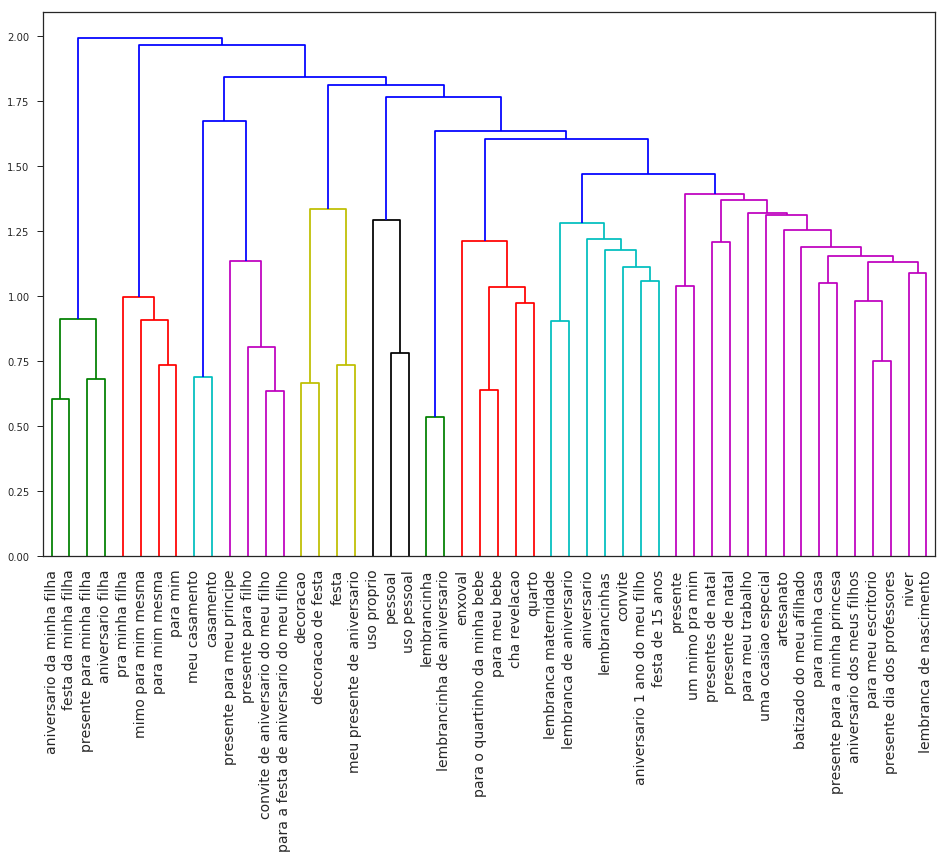

In [80]:
# plota o dendrograma
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=titles.values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

Qual foi o resultado? O que você faria para melhorar o resultado obtido?

---
# Case Elo7 - Subcategorias Automáticas

Vamos para mais um case real do Elo7!

Esse case é um dos trabalhos mais recentes do time de Data Science do Elo7. De fato, é um trabalho ainda em aberto e qualquer sugestão de melhorias é bem vinda! =)

- O problema:
O Elo7 possui uma árvore de categorias dividida em N1 e N2. O primeiro nível (N1) contém as categorias "alto nível" do site. São as categorias mais genéricas do marketplace- ou, pelo menos, é assim gostaríamos que fosse. As categorias N2, ou subcategorias, são as possíveis extensões dos nós das categorias N1. Podemos perceber que a árvore é extremamente limitada e isso é um problema grave não só para os compradores, que não conseguem navegar nas nossas categorias, mas também para os vendedores, que não conseguem categorizar bem seus produtos. A solução para esse problema seria uma árvore de categorias com maior "granularidade", ou seja, que consiga expandir além dos 2 níveis e ter mais subcategorias.

- O que o time de Data Science tem a ver com essa história? 

Bom, gerar uma nova árvore de categoria pode ser uma tarefa bastante monótona e cansativa. Provavelmente deve haver algum jeito de encontrar bons agrupamentos de produtos que pudessem servir como uma nova subcategoria. Talvez algum método de clustering que utilize como features o conteúdo dos produtos pode gerar algum resultado interessante.

- O experimento:

O dataset a seguir possui um subconjunto de produtos que foram categorizados na categoria N1 "Casamento". Escolhemos esse conjunto de dados para iniciar nossos trabalhos, porque assim temos mais controle sobre nossos resultados. E, também, porque é uma das categorias mais importantes do marketplace.

Para essa tarefa, vamos utilizar apenas o título e uma parte da descrição do produto (aprox. 140 caracteres) como features de entrada.

Vamos analisar os dados!

In [81]:
df_cat = pd.read_csv(os.path.join(DATASET_FOLDER, 'subcategory_elo7_dataset.csv'), sep=';')

df_cat.head(10)

,title,short_description,url
0,terco love ii niquel,vc quiser simular clique produto informe cep e...,https://www.elo7.com.br/jfndgm/dp/36CBDF
1,porta joias rustico,porta joias mdf presentear madrinhas lembranca...,https://www.elo7.com.br/jfndgm/dp/65FE78
2,convite casamento lisboa,compra minima 50 unidades convite casamento 15...,https://www.elo7.com.br/jfndgm/dp/2557F0
3,daminhas 82 00 cada,tecido cristal voal fino,https://www.elo7.com.br/jfndgm/dp/4D60B6
4,aromatizador,aromatizador ambientes varetas frasco vidro cu...,https://www.elo7.com.br/jfndgm/dp/5FECD3
5,chinelo casamento personalizado noivos,personalizamos qualquer tema foto precos difer...,https://www.elo7.com.br/jfndgm/dp/6B06A4
6,monograma brasao casamento modelo 91,monograma brasao casamento iniciais descricao ...,https://www.elo7.com.br/jfndgm/dp/B04210
7,caixa lembrancinhas papel,caixa cartonagem revestida papel detalhe fita ...,https://www.elo7.com.br/jfndgm/dp/28DF6F
8,body noiva personalizada,body personalizado madrinhas usarem despedida ...,https://www.elo7.com.br/jfndgm/dp/AAE311
9,quadro casamento mario geek nerd,ideal presente peca decoracao quadro eterniza ...,https://www.elo7.com.br/jfndgm/dp/8939E7


Vamos criar uma coluna com as features que vamos incluir no nosso modelo de aprendizagem.
Esse vetor de features será o título + descrição do produto. Para compensar a quantidade de palavras do título em relação a descrição, vamos repetir o título duas vezes.

In [82]:
df_cat['title_desc'] = (df_cat['title'] + ' ')*2 + df_cat['short_description']

df_cat.head(10)

,title,short_description,url,title_desc
0,terco love ii niquel,vc quiser simular clique produto informe cep e...,https://www.elo7.com.br/jfndgm/dp/36CBDF,terco love ii niquel terco love ii niquel vc q...
1,porta joias rustico,porta joias mdf presentear madrinhas lembranca...,https://www.elo7.com.br/jfndgm/dp/65FE78,porta joias rustico porta joias rustico porta ...
2,convite casamento lisboa,compra minima 50 unidades convite casamento 15...,https://www.elo7.com.br/jfndgm/dp/2557F0,convite casamento lisboa convite casamento lis...
3,daminhas 82 00 cada,tecido cristal voal fino,https://www.elo7.com.br/jfndgm/dp/4D60B6,daminhas 82 00 cada daminhas 82 00 cada tecido...
4,aromatizador,aromatizador ambientes varetas frasco vidro cu...,https://www.elo7.com.br/jfndgm/dp/5FECD3,aromatizador aromatizador aromatizador ambient...
5,chinelo casamento personalizado noivos,personalizamos qualquer tema foto precos difer...,https://www.elo7.com.br/jfndgm/dp/6B06A4,chinelo casamento personalizado noivos chinelo...
6,monograma brasao casamento modelo 91,monograma brasao casamento iniciais descricao ...,https://www.elo7.com.br/jfndgm/dp/B04210,monograma brasao casamento modelo 91 monograma...
7,caixa lembrancinhas papel,caixa cartonagem revestida papel detalhe fita ...,https://www.elo7.com.br/jfndgm/dp/28DF6F,caixa lembrancinhas papel caixa lembrancinhas ...
8,body noiva personalizada,body personalizado madrinhas usarem despedida ...,https://www.elo7.com.br/jfndgm/dp/AAE311,body noiva personalizada body noiva personaliz...
9,quadro casamento mario geek nerd,ideal presente peca decoracao quadro eterniza ...,https://www.elo7.com.br/jfndgm/dp/8939E7,quadro casamento mario geek nerd quadro casame...


A partir de agora é com você! Tente encontrar as subcategorias dos produtos da categoria "casamento". Lembre-se de que não queremos apenas aumentar o número de subcategorias do segundo nível (N2), mas também aumentar a profundidade da nossa árvore de categorias (N3, N4 ...).

In [83]:
# TODO

Para criar nossa matriz de features, nós vamos utilizar o Tf-Idf.

In [84]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=10000, sublinear_tf=True, use_idf=True)

In [85]:
X = tfidf.fit_transform(df_cat['title_desc'].values)

Novamente, precisamos definir o número de clusters. Podemos utilizar o método do gráfico de inércias.

(Obs: O cálculo pode levar muito tempo para ser executado. Assuma que o valor escolhido é 40)

In [ ]:
# Range de valores de clusters que vamos testar
k = range(10,100,10)

# Lista de inércias
inertias = []

# Para cada valor de k, ache a inércia
for i in k:
    # crie a instância
    kmeans = KMeans(n_clusters=i)

    # Treine o modelo
    model = kmeans.fit(X)

    # Ache a inercia dos clusters
    inertias.append(model.inertia_)
    
plt.plot(k, inertias, '-ob')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [93]:
kmeans = KMeans(n_clusters=40)

In [94]:
labels = kmeans.fit_predict(X)

In [95]:
df = pd.DataFrame({'title': df_cat['title'], 'labels': labels})

In [96]:
df.groupby('labels').size()

labels
0      7943
1      1805
2      1661
3       614
4      5251
5      1706
6      1738
7      1763
8      1882
9      1300
10     1076
11     1715
12     1073
13     1080
14     2778
15     1345
16      676
17     3560
18     3626
19     1087
20     3134
21      523
22     1871
23     2097
24      439
25      880
26     2176
27     1957
28     1324
29      678
30     4097
31      413
32     1099
33     1564
34      775
35      221
36      541
37    28387
38     2906
39     1239
dtype: int64

In [97]:
for idx in range(len(df['labels'].unique())):
    idx_labels = df[df['labels']==idx]['title'].unique()
    print('- Cluster {}:'.format(idx + 1))
    for i in np.random.choice(idx_labels, min(len(idx_labels), 10), replace=False):
        print(' '*5, i)
    print()

- Cluster 1:
      alice pais maravilhas convite
      convite casamento chalkbord quadro negro
      convites casamento renda
      convite sanfona padrinhos floral
      convite casamento moderno 06 50 unidades
      convite e3
      convite laco cetim tiago gabriela
      convite classico 9
      convite casamento tipo carta
      convite casamento caminho noiva

- Cluster 2:
      sabonete coracao lembrancinha
      sparkles coracao romantico
      lembrancinhas sachet coracao
      almofada p alianca branco cx coracao
      conjunto fronhas roubei coracao
      kit 10 mini pregadores coracao rosa
      lembrancinhas noivos
      balao metalizado formato coracao vermelho 44 cm 10 unid
      lembrancinha noivado coracao feltro
      caixa lembrancinhas coracao

- Cluster 3:
      prazo rapido 5 dias convite formatura
      convite padrinhos madrinhas
      numerados
      convite casamento
      convite casamento colecao esguio
      convites colecao royal casamento
      convite ca

In [98]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Y = linkage(kmeans.cluster_centers_, method='ward', metric='euclidean')

In [99]:
titles = df.groupby('labels').apply(lambda x: np.random.choice(list(x['title'])))

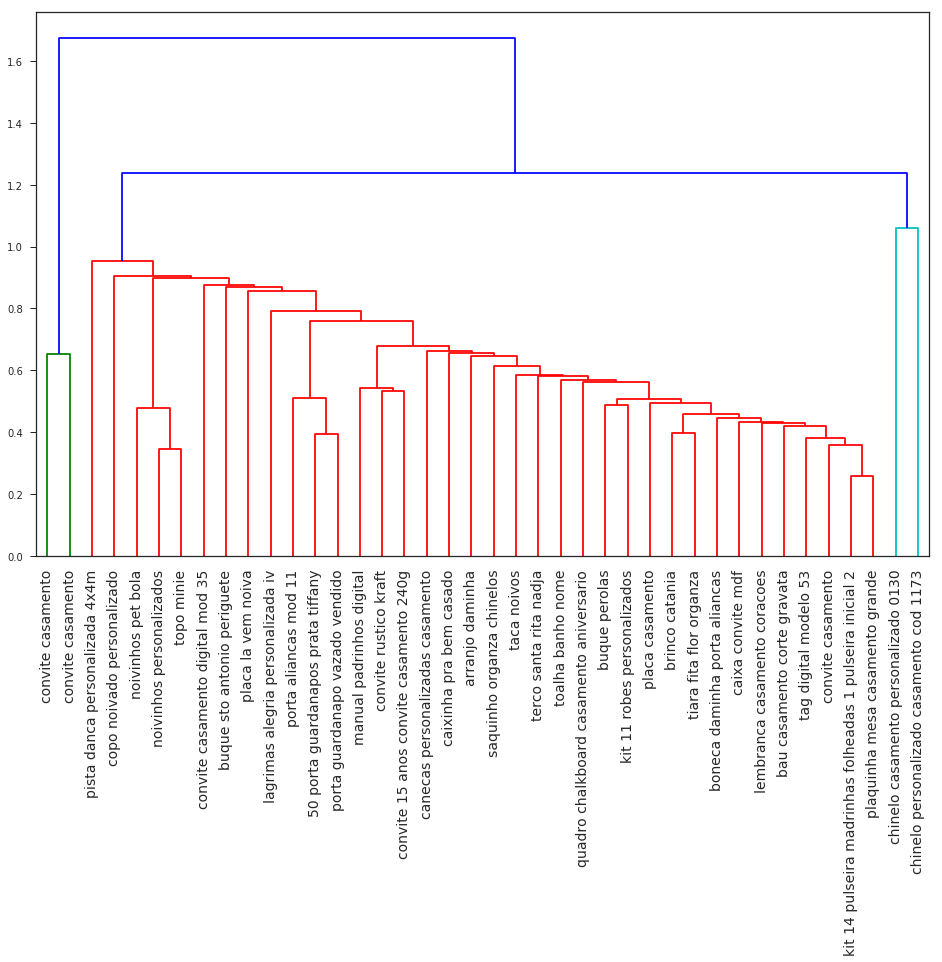

In [100]:
plt.figure(figsize=(16,10))
dendrogram(Y,
           labels=titles.values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

---
# Extra - DBSCAN


#### Perfil usuários Elo7
Vamos ver como ficaria o exemplo dos usuários do Elo7 utilizando DBSCAN.

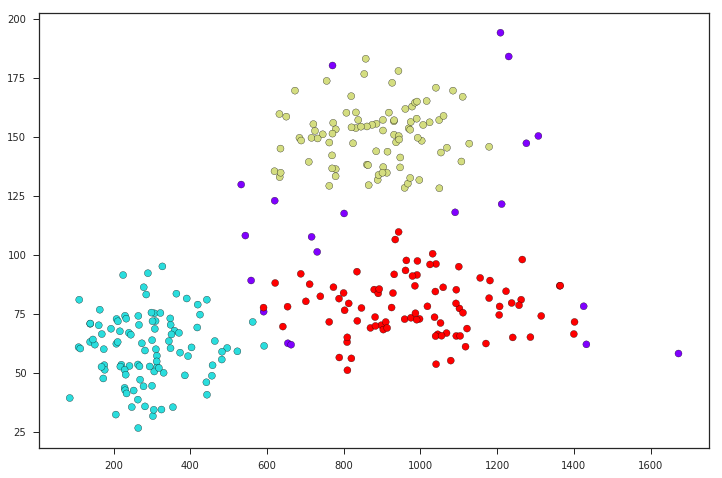

[-1  0  1  2]


In [101]:
from sklearn.cluster import DBSCAN

X = df_user_elo7.values

# Dados normalizados
X_scaled = StandardScaler().fit_transform(X)

estimator = DBSCAN(eps=0.33, min_samples=10, metric='euclidean')

estimator.fit(X_scaled)

labels = estimator.labels_
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=labels, 
            edgecolor='k',
            cmap='rainbow')
plt.show()
print(np.unique(labels))